In [1]:
!pip install shap
!pip install lime
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=2ea1bf68e1abf75a2c5ea0ff18607cc5563499fd3661e87d26518b8d1fae9acf
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.5 MB/s eta 0:00:00


In [2]:
import shap
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB, GaussianNB, CategoricalNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.utils import check_random_state
from sklearn.metrics import classification_report, confusion_matrix

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# LIME packages
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from sklearn.linear_model import Ridge, lars_path
from lime.lime_text import explanation
from functools import partial
import scipy as sp

from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
from tqdm import tqdm

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
!pip install gdown

In [4]:
'''
https://drive.google.com/file/d/1-DTIOsUZVbmiGJZMMmLbcSN_NWuqSbql/view?usp=drivesdk
https://drive.google.com/file/d/1-FAL4G--bLerOPdtHWoUb2FelHAc-cRN/view?usp=drivesdk
'''

'\nhttps://drive.google.com/file/d/1-DTIOsUZVbmiGJZMMmLbcSN_NWuqSbql/view?usp=drivesdk\nhttps://drive.google.com/file/d/1-FAL4G--bLerOPdtHWoUb2FelHAc-cRN/view?usp=drivesdk\n'

In [5]:
!gdown 1-DTIOsUZVbmiGJZMMmLbcSN_NWuqSbql
!gdown 1-FAL4G--bLerOPdtHWoUb2FelHAc-cRN

Downloading...
From: https://drive.google.com/uc?id=1-DTIOsUZVbmiGJZMMmLbcSN_NWuqSbql
To: /content/train.pkl
100% 3.00M/3.00M [00:00<00:00, 44.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-FAL4G--bLerOPdtHWoUb2FelHAc-cRN
To: /content/test.pkl
100% 638k/638k [00:00<00:00, 95.0MB/s]


In [6]:
FILE_PATH = "train.pkl"

with open(FILE_PATH, 'rb') as f:
    df_train = pickle.load(f)

In [7]:
FILE_PATH = "test.pkl"

with open(FILE_PATH, 'rb') as f:
    df_test = pickle.load(f)

In [8]:
df_train.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)

In [9]:
df_train.head()

,tweet,label,tweet_with_replaced_emojis,cleaned_data_with_replaced_emojis,Light Stemming
0,1996 يا مهند ياحبيبي انت تدور لبش مع اي احد ...,1,1996 يا مهند ياحبيبي انت تدور لبش مع اي احد ...,يامهند ياحبيبي تدور لبش اي احد متاكد ابو جاسم ...,يامهند ياحبيبي تدور لبش اي احد متاكد ابو جاسم ...
1,حلب عفرين اعتقال عشرات الشباب من قريه باسوطه ...,3,حلب عفرين اعتقال عشرات الشباب من قريه باسوطه ...,حلب عفرين اعتقال عشرات الشباب قريه باسوطه ريف ...,حلب عفر اعتقال عشر الشباب قريه باسوطه ريف عفر ...
2,انا نفسي مره اجرب اكون ليك حد اقرب : ),3,انا نفسي مره اجرب اكون ليك حد اقرب : ),مره اجرب اكون ليك اقرب,مره اجرب اكون ليك اقرب
3,الصراحه احساس مخزي ونحن نكتفي بالتمثيل المشرف ...,3,الصراحه احساس مخزي ونحن نكتفي بالتمثيل المشرف ...,الصراحه احساس مخزي نكتفي بالتمثيل المشرف الاول...,الصراحه احساس مخزي نكتفي بالتمثيل المشرف الاول...
4,57 عاجل الايطالي فابيو باسل يفوز بدهب الاولي...,0,57 عاجل الايطالي فابيو باسل يفوز بدهب الاولي...,عاجل الايطالي فابيو باسل يفوز بدهب الاوليمبياد...,عاجل الايطالي فابيو باسل يفوز بدهب الاوليمبياد...


In [10]:
marbert_model_path = 'UBC-NLP/MARBERT'
tokenizer = AutoTokenizer.from_pretrained(marbert_model_path, from_tf=True)
marbert_model = TFAutoModel.from_pretrained(marbert_model_path, output_hidden_states=True)

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at UBC-NLP/MARBERT.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [11]:
remove_special_tokens=1 #change this to 0 if you want to keep the special token
stemtype = 'Light Stemming'

In [12]:
def bert_tokenize(text: str) -> dict:
  tokens = tokenizer(text, padding='max_length', truncation=True, max_length=50)
  if remove_special_tokens == 1:
    shape = np.array(tokens['input_ids']).shape
    modified_input_ids = np.zeros(shape).astype(np.int32)
    modified_attention_mask = np.zeros(shape).astype(np.int32)
    # Modify the input IDs and attention mask as per your requirement
    for i in range(shape[0]):
      modified_input_ids[i] = [0 if token_id == 1 else 0 if token_id == 3 else 0 if token_id == 0 else 0 if token_id == 2 else 0 if token_id == 4 else token_id for token_id in tokens['input_ids'][i]]
      modified_attention_mask[i] = [0 if token_id in [1, 3, 0, 2, 4] else 1 for token_id in tokens['input_ids'][i]]
    # Update the input IDs and attention mask in the tokens dictionary
    tokens['input_ids'] = modified_input_ids
    tokens['attention_mask'] = modified_attention_mask
  return tokens

In [13]:
def get_embeddings(ids, mask, type_ids):
  ids = tf.convert_to_tensor(ids)
  mask = tf.convert_to_tensor(mask)
  type_ids = tf.convert_to_tensor(type_ids)
  hidden_states = marbert_model(input_ids=ids, attention_mask=mask, token_type_ids=type_ids)[0]
  averaged_embedding = tf.reduce_mean(hidden_states, axis=1)
  return averaged_embedding.numpy()

In [14]:
label_to_class = [
    'none',
    'anger',
    'joy',
    'sadness',
    'love',
    'sympathy',
    'surprise',
    'fear'
]
label_to_class_dic = {
    0:'none',
    1:'anger',
    2:'joy',
    3:'sadness',
    4:'love',
    5:'sympathy',
    6:'surprise',
    7:'fear'
}

In [15]:
def map_label_to_class(indices, classes):
  return [classes[idx] for idx in indices]

In [16]:
def create_confusion_matrix(y_pred):
  # creatin a confusion matrix
  y_true = map_label_to_class(df_test['label'], label_to_class)
  y_pred = map_label_to_class(y_pred, label_to_class)
  cm = confusion_matrix(y_true, y_pred, labels=label_to_class)
  # create a DataFrame for the confusion matrix with class names as index and columns
  cm_df = pd.DataFrame(cm, index=label_to_class, columns=label_to_class)

  # create a heatmap for visualization
  plt.figure(figsize=(5, 5))
  sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

In [17]:
x_train = df_train[stemtype].values.astype(str).tolist()
x_train = bert_tokenize(x_train)

xlen = np.array(x_train['input_ids']).shape[0]

In [18]:
x_train_emb = np.zeros((xlen,768))
for i in range(0,xlen,100):
  if(i+100 < xlen):
    input_ids = x_train['input_ids'][i:i+100]
    attention_mask = x_train['attention_mask'][i:i+100]
    token_type_ids = x_train['token_type_ids'][i:i+100]
    x_train_emb[i:i+100] = get_embeddings(input_ids,attention_mask,token_type_ids)
  else:
    input_ids = x_train['input_ids'][i:xlen]
    attention_mask = x_train['attention_mask'][i:xlen]
    token_type_ids = x_train['token_type_ids'][i:xlen]
    x_train_emb[i:xlen] = get_embeddings(input_ids,attention_mask,token_type_ids)

In [19]:
x_test = df_test[stemtype].values.astype(str).tolist()
x_test = bert_tokenize(x_test)

xlen = np.array(x_test['input_ids']).shape[0]

In [20]:
x_test_emb = np.zeros((xlen,768))
for i in range(0,xlen,100):
  if(i+100 < xlen):
    input_ids = x_test['input_ids'][i:i+100]
    attention_mask = x_test['attention_mask'][i:i+100]
    token_type_ids = x_test['token_type_ids'][i:i+100]
    x_test_emb[i:i+100] = get_embeddings(input_ids,attention_mask,token_type_ids)
  else:
    input_ids = x_test['input_ids'][i:xlen]
    attention_mask = x_test['attention_mask'][i:xlen]
    token_type_ids = x_test['token_type_ids'][i:xlen]
    x_test_emb[i:xlen] = get_embeddings(input_ids,attention_mask,token_type_ids)

## Naive Bayes

In [63]:
nb_ls = GaussianNB(var_smoothing=1e-6)
nb_ls.fit(x_train_emb, df_train['label'])

# test accuracy of light stemming embeddings
y_pred = nb_ls.predict(x_test_emb)
# calculating the accuracy of the classifier
accuracy = accuracy_score(df_test['label'], y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.49205298013245036


In [64]:
print(classification_report(df_test['label'], y_pred, target_names = label_to_class))

              precision    recall  f1-score   support

        none       0.54      0.84      0.66       229
       anger       0.43      0.56      0.48       200
         joy       0.38      0.28      0.32       205
     sadness       0.34      0.25      0.29       185
        love       0.49      0.62      0.54       193
    sympathy       0.65      0.50      0.57       156
    surprise       0.36      0.27      0.30       154
        fear       0.77      0.53      0.63       188

    accuracy                           0.49      1510
   macro avg       0.49      0.48      0.47      1510
weighted avg       0.49      0.49      0.48      1510



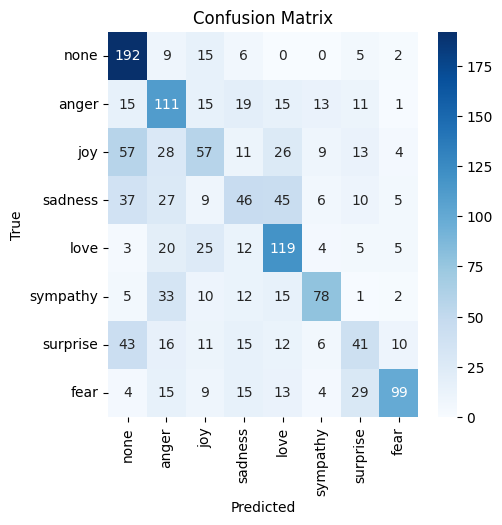

In [65]:
create_confusion_matrix(y_pred)

## MultinomialNB

In [66]:
from sklearn.feature_extraction.text import CountVectorizer
# Create a CountVectorizer
vectorizer = CountVectorizer()

# Transform the text data into a document-term matrix
X_train_counts = vectorizer.fit_transform(df_train["Light Stemming"])
X_test_counts = vectorizer.transform(df_test["Light Stemming"])

# Create and train a Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train_counts, df_train["label"])

# Predict labels for the test set
y_pred_mn = classifier.predict(X_test_counts)

# Evaluate the classifier
accuracy = accuracy_score(df_test["label"], y_pred_mn)
print("Accuracy:", accuracy)

Accuracy: 0.6185430463576159


## LIME

In [67]:
def model_predict(text):
  tokens = bert_tokenize(text)
  xlen = np.array(tokens['input_ids']).shape[0]
  x_emb = np.zeros((xlen,768))
  for i in range(0,xlen,100):
    if(i+100 < xlen):
      input_ids = tokens['input_ids'][i:i+100]
      attention_mask = tokens['attention_mask'][i:i+100]
      token_type_ids = tokens['token_type_ids'][i:i+100]
      x_emb[i:i+100] = get_embeddings(input_ids,attention_mask,token_type_ids)
    else:
      input_ids = tokens['input_ids'][i:xlen]
      attention_mask = tokens['attention_mask'][i:xlen]
      token_type_ids = tokens['token_type_ids'][i:xlen]
      x_emb[i:xlen] = get_embeddings(input_ids,attention_mask,token_type_ids)
  return nb_ls.predict_proba(x_emb)

## SHAP

In [68]:
def shap_model_predict(text):
  text = text.astype(str).tolist()
  tokens = bert_tokenize(text)
  xlen = np.array(tokens['input_ids']).shape[0]
  x_emb = np.zeros((xlen,768))
  for i in range(0,xlen,100):
    if(i+100 < xlen):
      input_ids = tokens['input_ids'][i:i+100]
      attention_mask = tokens['attention_mask'][i:i+100]
      token_type_ids = tokens['token_type_ids'][i:i+100]
      x_emb[i:i+100] = get_embeddings(input_ids,attention_mask,token_type_ids)
    else:
      input_ids = tokens['input_ids'][i:xlen]
      attention_mask = tokens['attention_mask'][i:xlen]
      token_type_ids = tokens['token_type_ids'][i:xlen]
      x_emb[i:xlen] = get_embeddings(input_ids,attention_mask,token_type_ids)
  return nb_ls.predict_proba(x_emb)

In [69]:
'''
function that initializes shap with the appropriate model
parameters
model: an instance of your model, ex: LogisticRegression instance
'''
def initializeShap(model):
  # split input text into tokens
  masker = shap.maskers.Text(tokenizer=r"\W+")
  explainer = shap.Explainer(shap_model_predict, masker=masker, output_names=label_to_class)
  return explainer

## Exploration

In [70]:
nb_explainer = initializeShap(model=nb_ls)

In [71]:
def explain_example_lime(i, class_to_explain):
  instance = df_test["Light Stemming"].iloc[i]
  print(df_test["tweet"].iloc[i])
  explainer = LimeTextExplainer(class_names=label_to_class)
  explanation = explainer.explain_instance(instance, model_predict, num_features=10, labels=[class_to_explain])
  explanation.show_in_notebook()

In [72]:
def explain_example_shap(i, class_to_explain):
  instance = df_test["Light Stemming"].iloc[i:i+1].values.astype(str).tolist()
  print(df_test["tweet"].iloc[i])
  shap_values = nb_explainer(instance)
  # waterfall plot
  shap.plots.waterfall(shap_values[0][:, class_to_explain])

In [73]:
y_true = df_test['label']

In [74]:
# get correctly and incorrectly classified examples
correctly_classified, incorrectly_classified = [], []
for i in range(len(y_true)):
  if y_pred[i] == y_true[i]:  correctly_classified.append(i)
  else: incorrectly_classified.append(i)

## find specific words

### loop through all incorrectly classifies examples and exctract the most common words that led to the wrong classfication

In [75]:
def get_word_frequency(df):
  # creating a dictionary to hold the number of times a specific word occurs
  word_frequency = {}
  for idx in incorrectly_classified:
    # tokenizing the words
    words_to_add = word_tokenize(df.iloc[idx])
    # looping through each word in list
    for word in words_to_add:
      if word in word_frequency:
        word_frequency[word] += 1
      else: word_frequency[word] = 1
  # soring the dictionary from most common words to least common
  sorted_list = sorted(word_frequency.items(), key=lambda word: word[1], reverse=True)
  return sorted_list

In [76]:
word_freq = get_word_frequency(df_test["Light Stemming"])

In [77]:
# getting 10 most common words
print(word_freq[:10])

[('الاوليمبياد', 191), ('حزن', 80), ('اللي', 69), ('لا', 65), ('سخريه', 63), ('الله', 61), ('حب', 59), ('مصر', 48), ('فرح', 44), ('مش', 44)]


### as we can see above are the most common words that lead to missclassification, lets try to understand why?

In [78]:
# see how the words above influence the classes
def word_occurance(word, df, y_pred):
  label_dic = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
  for idx in incorrectly_classified:
    if word in df.iloc[idx]:
      label_dic[y_pred[idx]] += 1
  # create a new dictionary using label_to_class as keys
  new_dict = {label: label_dic.get(index, 0) for index, label in enumerate(label_to_class)}
  return new_dict

In [79]:
problamatic_words = [word[0] for word in word_freq[:10]]
print(problamatic_words)

['الاوليمبياد', 'حزن', 'اللي', 'لا', 'سخريه', 'الله', 'حب', 'مصر', 'فرح', 'مش']


In [80]:
for word in problamatic_words:
  dic = word_occurance(word, df_test["Light Stemming"], y_pred)
  print(f"Classes for Word {word}:\n{dic}", end="\n\n")

Classes for Word الاوليمبياد:
{'none': 127, 'anger': 14, 'joy': 16, 'sadness': 13, 'love': 3, 'sympathy': 1, 'surprise': 12, 'fear': 1}

Classes for Word حزن:
{'none': 3, 'anger': 9, 'joy': 6, 'sadness': 11, 'love': 21, 'sympathy': 3, 'surprise': 4, 'fear': 1}

Classes for Word اللي:
{'none': 27, 'anger': 10, 'joy': 6, 'sadness': 12, 'love': 5, 'sympathy': 1, 'surprise': 9, 'fear': 2}

Classes for Word لا:
{'none': 142, 'anger': 86, 'joy': 37, 'sadness': 62, 'love': 59, 'sympathy': 24, 'surprise': 34, 'fear': 7}

Classes for Word سخريه:
{'none': 11, 'anger': 6, 'joy': 4, 'sadness': 4, 'love': 2, 'sympathy': 0, 'surprise': 3, 'fear': 2}

Classes for Word الله:
{'none': 12, 'anger': 21, 'joy': 10, 'sadness': 10, 'love': 13, 'sympathy': 10, 'surprise': 4, 'fear': 4}

Classes for Word حب:
{'none': 8, 'anger': 13, 'joy': 16, 'sadness': 14, 'love': 35, 'sympathy': 3, 'surprise': 4, 'fear': 3}

Classes for Word مصر:
{'none': 46, 'anger': 13, 'joy': 2, 'sadness': 5, 'love': 2, 'sympathy': 1, '

In [81]:
def show_example(idx):
  print(f"True Label {label_to_class_dic[y_true[idx]]} - Predicted Label {label_to_class_dic[y_pred[idx]]}")
  print(f"Explaining according to label {label_to_class_dic[y_pred[idx]]}")
  print(df_test["tweet"].iloc[idx])
  print(df_test["Light Stemming"].iloc[idx])

In [82]:
def explain_example(idx, explainer="lime"):
  print(f"True Label {label_to_class_dic[y_true[idx]]} - Predicted Label {label_to_class_dic[y_pred[idx]]}")
  print(f"Explaining according to label {label_to_class_dic[y_pred[idx]]}")
  if explainer == "shap":
    explain_example_shap(idx, y_pred[idx])
  else: explain_example_lime(idx, y_pred[idx])

## short statements

In [83]:
short_statements = []
for i in range(len(df_test)):
  if len(df_test["Light Stemming"].iloc[i]) <= 5:
    short_statements.append(i)

In [84]:
len(short_statements)

16

In [85]:
# see how the words above influence the classes
def word_occurance_train(word, df, df_label):
  examples = [[] for i in range(8)]
  label_dic = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
  for idx in range(len(df)):
    if word in df.iloc[idx]:
      label_dic[df_label.iloc[idx]] += 1
      examples[df_label.iloc[idx]].append(df.iloc[idx] + f" label: {label_to_class[df_label.iloc[idx]]}")
  # create a new dictionary using label_to_class as keys
  new_dict = {label: label_dic.get(index, 0) for index, label in enumerate(label_to_class)}
  return new_dict, examples

In [86]:
idx = 0
print(df_test["tweet"].iloc[short_statements[idx]])
print(df_test["Light Stemming"].iloc[short_statements[idx]])
print(f"True Label: {label_to_class_dic[y_true[short_statements[idx]]]} - Predicted Label: {label_to_class_dic[y_pred[short_statements[idx]]]}")

NAME?

True Label: none - Predicted Label: fear


In [87]:
idx = 1
print(df_test["tweet"].iloc[short_statements[idx]])
print(df_test["Light Stemming"].iloc[short_statements[idx]])
print(f"True Label: {label_to_class_dic[y_true[short_statements[idx]]]}")
print(f"Predicted Label using GaussianNB: {label_to_class_dic[y_pred[short_statements[idx]]]}")
print(f"Predicted Label using MultinomialNB: {label_to_class_dic[y_pred_mn[short_statements[idx]]]}")

lolo123   sabah   صباح الفل
الفل
True Label: joy
Predicted Label using GaussianNB: joy
Predicted Label using MultinomialNB: joy


In [45]:
new_dict, examples = word_occurance_train("الفل", df_train["Light Stemming"], df_train["label"])
print(new_dict)
for label_ex in examples:
  for ex in label_ex: print(ex)

{'none': 2, 'anger': 5, 'joy': 2, 'sadness': 4, 'love': 2, 'sympathy': 3, 'surprise': 4, 'fear': 0}
الفل ياابراهيم تكلم شويه سيرجي بوبكا واليكسندر كارل بمناسبه الاوليمبياد label: none
افتتاح الالعاب الاوليمبياد ريو جانيرو البرازيل دخول الفريق الفلسطي label: none
لا تتريق ياالفله شف وجهك اول وبعد وش دخل ال سعود الموضوع label: anger
الانكشاري اردوغ يعري الجنود الاتراك فعلت اسرائيل بالسجناء الفلسطين اريحا النازي الامريك سجن label: anger
اليهود انفس يتبر العصابه الصهيونيه المحتله للاراضي الفلسطينيه سعودي ضد التطبيع label: anger
ماخذبالقوه لن يستردالابالقوه والصهاينه اغتصبو فلسط بالقوه بدعم الاستعمار وتواطيءوتخاذل العرب وخيانه الفلسطين label: anger
للاسف الان الفلسطين نتم تجريد العرب السنت خونت حتي نستطيع تحرير القدس وفلسط لوحد يطعن العرب label: anger
اشطه لول ياوي نتايج حلوه الاوليمبياد والبلد زي الفل وماشيه نجاح وانا بحب احارب النجاح اللي سخريه سخريه فرح label: joy
لا خالص الكنت بضحك الفل label: joy
اول سافرت مصر حصلي دروب صعب والفلوس اللي معا اتسرقت ومكانش مكان انام والحياه قفلت وشي labe

In [88]:
idx = 2
print(df_test["tweet"].iloc[short_statements[idx]])
print(df_test["Light Stemming"].iloc[short_statements[idx]])
print(f"True Label: {label_to_class_dic[y_true[short_statements[idx]]]}")
print(f"Predicted Label using GaussianNB: {label_to_class_dic[y_pred[short_statements[idx]]]}")
print(f"Predicted Label using MultinomialNB: {label_to_class_dic[y_pred_mn[short_statements[idx]]]}")

انا سعيده.
سعيده
True Label: joy
Predicted Label using GaussianNB: fear
Predicted Label using MultinomialNB: joy


In [89]:
new_dict, examples = word_occurance_train("سعيده", df_train["Light Stemming"], df_train["label"])
print(new_dict)
for label_ex in examples:
  for ex in label_ex: print(ex)

{'none': 0, 'anger': 0, 'joy': 4, 'sadness': 0, 'love': 1, 'sympathy': 0, 'surprise': 0, 'fear': 0}
سنه وانت طيب وسنه سعيده عليك يارب وداي متجمع المحبه label: joy
سنه وانت طيب ياصاحبي وعقبال سنه ويارب سنه سعيده وتحقق احلامك حب راي label: joy
اتم امسيه سعيده فرح وسرور label: joy
الحاج السعيده اللي حصلت الاسبوع برضو ديلبوترو طلع اللطخ نوڤاك الدور الاول الاوليمبياد label: joy
اللحظ السعيده بصحبه نحب صباحي انتم صباح حب حب label: love


In [91]:
idx = 3
print(df_test["tweet"].iloc[short_statements[idx]])
print(df_test["Light Stemming"].iloc[short_statements[idx]])
print(f"True Label: {label_to_class_dic[y_true[short_statements[idx]]]}")
print(f"Predicted Label using GaussianNB: {label_to_class_dic[y_pred[short_statements[idx]]]}")
print(f"Predicted Label using MultinomialNB: {label_to_class_dic[y_pred_mn[short_statements[idx]]]}")

وقلبي معكم ...
وقلبي
True Label: sympathy
Predicted Label using GaussianNB: sympathy
Predicted Label using MultinomialNB: love


In [92]:
new_dict, examples = word_occurance_train("وقلبي", df_train["Light Stemming"], df_train["label"])
print(new_dict)
for label_ex in examples:
  for ex in label_ex: print(ex)

{'none': 0, 'anger': 0, 'joy': 0, 'sadness': 0, 'love': 2, 'sympathy': 0, 'surprise': 0, 'fear': 1}
ويظن اني امي لغي ره اني وقلبي باسمه مكتوب شربت الحب الا مره والكل كاسه مسكوب شعر حب label: love
عيون صغيره وقلبي يعشق تحمل الملامح ابي شهد العسل محيا وحروف اسم الدليل درب الصداقه للدعم label: love
امانه شعور يقهر خايفه مدري ايش يدي ترجف وقلبي يوجع وحرارتي ارتفعت مدري شفي وجع خلاص label: fear


In [93]:
idx = 4
print(df_test["tweet"].iloc[short_statements[idx]])
print(df_test["Light Stemming"].iloc[short_statements[idx]])
print(f"True Label: {label_to_class_dic[y_true[short_statements[idx]]]}")
print(f"Predicted Label using GaussianNB: {label_to_class_dic[y_pred[short_statements[idx]]]}")
print(f"Predicted Label using MultinomialNB: {label_to_class_dic[y_pred_mn[short_statements[idx]]]}")

هو انت عايش ؟!!!!
عايش
True Label: surprise
Predicted Label using GaussianNB: love
Predicted Label using MultinomialNB: sadness


In [94]:
new_dict, examples = word_occurance_train("عايش", df_train["Light Stemming"], df_train["label"])
print(new_dict)
for label_ex in examples:
  for ex in label_ex: print(ex)

{'none': 2, 'anger': 7, 'joy': 2, 'sadness': 9, 'love': 2, 'sympathy': 3, 'surprise': 7, 'fear': 4}
البرلم ارسل خمسه اعضائه لحضور الاوليمبياد بهدف كسب وتبادل الخبر ومعايشه اللاعب والتعرف اسباب حصول الدول الميدالي label: none
كريم الزغبي الفارس المصري المشارك الاوليمبياد عايش هولندا والحص بتاعه واكيد المدرب بتوعه الجميل بقي فريق كامل label: none
مهزرتش معاك اصلا عشان عامل مقموص وعايش الدور واللي هزرت معا ناس ليا معا هزار label: anger
اخردوري للهلال القذافي عايش وحس مبارك رئيس مصروالشعب السعودي يروح سياحه سورياعلي صالح يخزن قات بالقصرالجمهوري فساد الله لا label: anger
ليه عايش المفروض يست اما يموت يرجع البلد معزز مكرم بلد مش بتفتكر الناس يموت ادعم دكتور محمد امام label: anger
اقسم بالله مندهشه مش مصدقه اللي الناس وصلتله ليه استفدت وعايش مبسوط عادي مش بيانيك ضميرك label: anger
اكبر طائفي وحاقد ومسموم واتم الله يفضحك امام الشيعه تقول انك متعايش label: anger
جثم احمد زويل يرجع سليم الامريك مش هيسيبوه هيشيله لان عايش الاستنساخ ابعت وزير الخارجيه اللي هيشل السيسي شيري label: anger
لازم نستفيد

In [56]:
idx = 5
print(df_test["Light Stemming"].iloc[short_statements[idx]])
print(f"True Label: {label_to_class_dic[y_true[short_statements[idx]]]} - Predicted Label: {label_to_class_dic[y_pred[short_statements[idx]]]}")

ازعل
True Label: surprise - Predicted Label: love


as we can see there are a lot of one word tweets and 15 tweets of length 5 or less, there's and even empty tweet after preprocessing.

## Is there a lack of sufficient training data for a particular label?

In [48]:
df_train['label'].value_counts()

0    1074
1    1019
2     891
3     885
4     850
7     842
5     755
6     729
Name: label, dtype: int64

class surprise has 300+ less examples than none, but is that enough to make a big difference?
however when you think about it in terms of ratio 300 is almost a third of number of examples of none.

### Observation: root stemming seems to break the words meaning and reduce accuracy below the no stemming, however light stemming seems to preserve word meaning and even improve the baseline accuracy

In [49]:
# use Tfidf Vectorizer light stemming
tfidf_vectorizer = TfidfVectorizer()

# fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['Light Stemming'])
# transform the test data using the same vectorizer
X_test_tfidf = tfidf_vectorizer.transform(df_test['Light Stemming'])

nb_large = GaussianNB(var_smoothing=1e-6)
nb_large.fit(X_train_tfidf.toarray(), df_train['label'])


y_pred = nb_large.predict(X_test_tfidf.toarray())
# calculating the accuracy of the classifier
accuracy = accuracy_score(df_test['label'], y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.44039735099337746


In [50]:
print(classification_report(df_test['label'], y_pred, target_names = label_to_class))

              precision    recall  f1-score   support

        none       0.45      0.44      0.45       229
       anger       0.48      0.59      0.53       200
         joy       0.39      0.28      0.33       205
     sadness       0.28      0.28      0.28       185
        love       0.53      0.54      0.53       193
    sympathy       0.62      0.59      0.60       156
    surprise       0.27      0.30      0.28       154
        fear       0.49      0.50      0.49       188

    accuracy                           0.44      1510
   macro avg       0.44      0.44      0.44      1510
weighted avg       0.44      0.44      0.44      1510



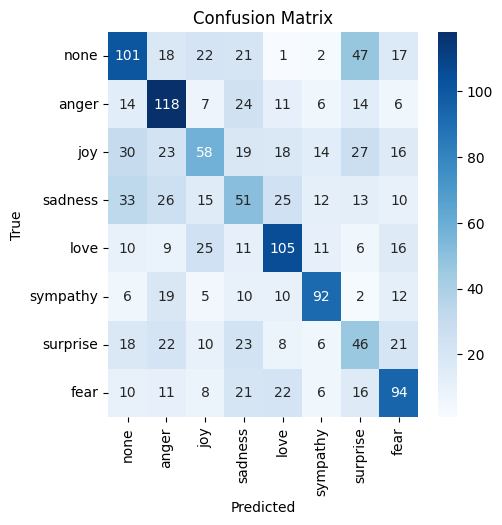

In [51]:
create_confusion_matrix(y_pred)

In [52]:
x_train, y_train = [], []
counts = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}

for i in range(len(df_train)):
  if counts[df_train["label"].iloc[i]] < 729:
    counts[df_train["label"].iloc[i]] += 1
    x_train.append(df_train["Light Stemming"].iloc[i])
    y_train.append(df_train["label"].iloc[i])

In [53]:
len(x_train), 729 * 8

(5832, 5832)

In [54]:
# use Tfidf Vectorizer light stemming
tfidf_vectorizer = TfidfVectorizer()

# fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
# transform the test data using the same vectorizer
X_test_tfidf = tfidf_vectorizer.transform(df_test['Light Stemming'])

nb_small = GaussianNB(var_smoothing=1e-6)
nb_small.fit(X_train_tfidf.toarray(), y_train)


y_pred = nb_small.predict(X_test_tfidf.toarray())
# calculating the accuracy of the classifier
accuracy = accuracy_score(df_test['label'], y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.44039735099337746


In [55]:
print(classification_report(df_test['label'], y_pred, target_names = label_to_class))

              precision    recall  f1-score   support

        none       0.48      0.48      0.48       229
       anger       0.50      0.52      0.51       200
         joy       0.37      0.26      0.30       205
     sadness       0.29      0.29      0.29       185
        love       0.53      0.52      0.53       193
    sympathy       0.58      0.62      0.60       156
    surprise       0.26      0.27      0.26       154
        fear       0.46      0.55      0.50       188

    accuracy                           0.44      1510
   macro avg       0.43      0.44      0.44      1510
weighted avg       0.44      0.44      0.44      1510



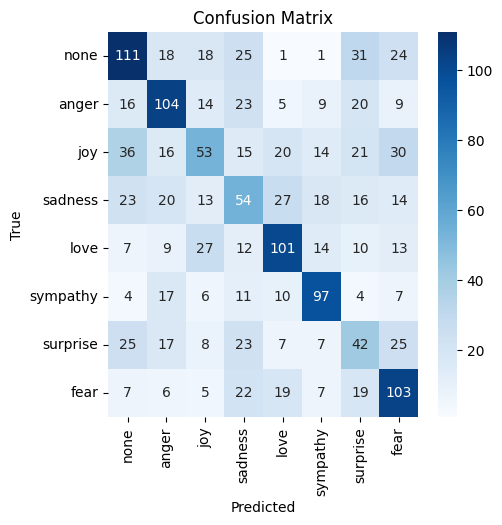

In [56]:
create_confusion_matrix(y_pred)

In [59]:
from sklearn.feature_extraction.text import CountVectorizer
# Create a CountVectorizer
vectorizer = CountVectorizer()

# Transform the text data into a document-term matrix
X_train_counts = vectorizer.fit_transform(x_train)
X_test_counts = vectorizer.transform(df_test["Light Stemming"])

# Create and train a Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train_counts, y_train)

# Predict labels for the test set
y_pred = classifier.predict(X_test_counts)

# Evaluate the classifier
accuracy = accuracy_score(df_test["label"], y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6192052980132451
